In [1]:
import parmed as pmd
import emcee
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from KDEpy import FFTKDE
from scipy import constants
from scipy.optimize import minimize


In [2]:
gmx = pmd.gromacs.GromacsTopologyFile("charmm_ff/forcefield.itp")
param_set = pmd.charmm.parameters.CharmmParameterSet.from_parameterset(gmx.parameterset)

In [19]:
for cmap_type in param_set.cmap_types.values():
    print(np.exp(np.array(cmap_type.grid._data)).max())

845.5607358510359
845.5607358510359
845.5607358510359
845.5607358510359
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
845.5607358510359
845.5607358510359
845.5607358510359
845.5607358510359
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
128.95970613166207
128.95970613166207
931.9694172148131
931.9694172148131
846.923185113112
846.923185113112
846.923185113112
846.923185113112
846.923185113112
846.923185113112
846.923185113112
846.923185113112
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224


In [18]:
eps = np.finfo(np.float32).eps

1e-3 * 5.134644231712484e-06 / eps

0.0430725176792972

In [12]:
eps / 5.134644231712484e-06

0.023216660039370066

In [4]:
param_set.cmap_types

OrderedDict([(('C', 'NH1', 'CT1', 'C', 'NH1', 'CT1', 'C', 'NH1'),
              <CmapType; resolution=24>),
             (('NH1', 'C', 'CT1', 'NH1', 'C', 'CT1', 'NH1', 'C'),
              <CmapType; resolution=24>),
             (('C', 'NH1', 'CT1', 'C', 'NH1', 'CT1', 'C', 'N'),
              <CmapType; resolution=24>),
             (('N', 'C', 'CT1', 'NH1', 'C', 'CT1', 'NH1', 'C'),
              <CmapType; resolution=24>),
             (('C', 'N', 'CP1', 'C', 'N', 'CP1', 'C', 'NH1'),
              <CmapType; resolution=24>),
             (('NH1', 'C', 'CP1', 'N', 'C', 'CP1', 'N', 'C'),
              <CmapType; resolution=24>),
             (('C', 'N', 'CP1', 'C', 'N', 'CP1', 'C', 'N'),
              <CmapType; resolution=24>),
             (('N', 'C', 'CP1', 'N', 'C', 'CP1', 'N', 'C'),
              <CmapType; resolution=24>),
             (('C', 'NH1', 'CT2', 'C', 'NH1', 'CT2', 'C', 'NH1'),
              <CmapType; resolution=24>),
             (('NH1', 'C', 'CT2', 'NH1', 'C', 'CT2',

In [24]:

def build_logp(cmap_type):
    RT = 0.592 # kcal / mol
    # R = constants.R / (constants.calorie * 1e3)
    # RT = R * 298

    res = cmap_type.resolution
    V = np.array(cmap_type.grid).reshape(res, res)
    logp = -V / RT
    # logp = -V

    ext_logp = np.empty([dim + 1 for dim in logp.shape])

    ext_logp[:-1, :-1] = logp
    ext_logp[:-1, -1] = logp[:, 0]
    ext_logp[-1, :-1] = logp[0, :]
    ext_logp[-1, -1] = logp[0, 0]

    return ext_logp

logps = [build_logp(cmap_type) for cmap_type in param_set.cmap_types.values()]
# logps = [logp for logp in logps if np.exp(logp.min()) == 1.1615857613434818e-09]


In [25]:
for logp in logps:
    print(logp.min())

-11.385135135135135
-11.385135135135135
-11.385135135135135
-11.385135135135135
-20.573479729729733
-20.573479729729733
-20.573479729729733
-20.573479729729733
-6.256756756756757
-6.256756756756757
-6.256756756756757
-6.256756756756757
-11.385135135135135
-11.385135135135135
-11.385135135135135
-11.385135135135135
-20.573479729729733
-20.573479729729733
-20.573479729729733
-20.573479729729733
-8.208614864864865
-8.208614864864865
-11.549493243243242
-11.549493243243242
-11.38785472972973
-11.38785472972973
-11.38785472972973
-11.38785472972973
-11.38785472972973
-11.38785472972973
-11.38785472972973
-11.38785472972973
-20.573479729729733
-20.573479729729733
-20.573479729729733
-20.573479729729733
-20.573479729729733
-20.573479729729733
-20.573479729729733
-20.573479729729733
-6.256756756756757
-6.256756756756757
-6.256756756756757
-6.256756756756757
-6.256756756756757
-6.256756756756757
-6.256756756756757
-6.256756756756757


In [16]:
res = next(iter(logps)).shape[0]

angs = np.linspace(-np.pi, np.pi, res)
method = "slinear"

interps = [RegularGridInterpolator((angs, angs), logp, method=method) for logp in logps]


In [17]:
def log_prob(x, interp):
    mask = np.any((x < -np.pi) | (x > np.pi), axis=1)
    x[mask, :] = np.array([0.0, 0.0])
    logp = interp(x)
    logp[mask] = -np.inf
    return logp

In [40]:
from math import ceil

def sample(interp, nsamples):
    ndim = 2
    nwalkers = 32
    # nwalkers = 4
    samples_per_chain = ceil(nsamples / nwalkers)
    p0 = np.pi * (2 * np.random.rand(nwalkers, ndim) - 1)

    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[interp], vectorize=True)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[interp], vectorize=False)
    sampler.run_mcmc(p0, 1_000 + samples_per_chain)

    samples = sampler.get_chain()
    return samples[-samples_per_chain:].reshape(-1, 2)


samples_arr = []

for interp in interps:
    samples_arr.append(sample(interp, 600_000))
    # samples_arr.append(sample(interp, 1_000))

emcee: Exception while calling your likelihood function:
  params: [-2.66058411  0.842561  ]
  args: [<scipy.interpolate._rgi.RegularGridInterpolator object at 0x7fa99905b290>]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1045313/906104579.py", line 2, in log_prob
    mask = np.any((x < -np.pi) | (x > np.pi), axis=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/numpy/core/fromnumeric.py", line 2412, in any
    return _wrapreduction(a, np.logical_or, 'any', axis, None, out,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/numpy/core/fromnumeric.py", line 88, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
numpy.exceptions.AxisError: axis 1 is out of bounds for array of dime

AxisError: axis 1 is out of bounds for array of dimension 1

In [41]:
sample(interp, 60_000)

emcee: Exception while calling your likelihood function:
  params: [ 0.94751234 -3.13999916]
  args: [<scipy.interpolate._rgi.RegularGridInterpolator object at 0x7fa99905b290>]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1045313/906104579.py", line 2, in log_prob
    mask = np.any((x < -np.pi) | (x > np.pi), axis=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/numpy/core/fromnumeric.py", line 2412, in any
    return _wrapreduction(a, np.logical_or, 'any', axis, None, out,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/numpy/core/fromnumeric.py", line 88, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
numpy.exceptions.AxisError: axis 1 is out of bounds for array of dime

AxisError: axis 1 is out of bounds for array of dimension 1

In [29]:
kernel = "gaussian"
factor = 10
l = (res - 1) * factor
angs = np.linspace(-np.pi, np.pi, l + 1)
kde_grid = np.stack(np.meshgrid(angs, angs, indexing="ij"), axis=-1).reshape(-1, 2)
assert np.allclose(angs[::factor], np.linspace(-np.pi, np.pi, res))

In [30]:
def loss(x, samples, true_logp):
    # bw, eps = x
    (bw, k) = x
    # eps = 5.134644231712484e-06
    eps = 1.1615857613434818e-09
    kde = FFTKDE(bw=bw, kernel=kernel)
    kde.fit(samples)

    pdf = kde.evaluate(kde_grid).reshape(l + 1, l + 1)
    pdf = pdf[::factor, ::factor]

    # est_logp = np.log(pdf + np.exp(eps))
    est_logp = np.log(k * pdf + eps)

    return np.sum((est_logp[:-1, :-1] - true_logp[:-1, :-1]) ** 2)

# def cum_loss(x, samples_arr, logps):
#     tot = 0.0

#     for samples, true_logp in zip(samples_arr, logps):
#         tot += loss(x, samples, true_logp)

#     return tot

In [31]:
# out = minimize(cum_loss, x0=[2e-1], bounds=[(1e-5, 10)], args=(samples_arr, logps))

In [32]:
#   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
#   success: True
#    status: 0
#       fun: 74556.91129774158
#         x: [ 3.002e-01]
#       nit: 14
#       jac: [ 8.310e+03]
#      nfev: 298
#      njev: 149
#  hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


#   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
#   success: True
#    status: 0
#       fun: 137949.50214250557
#         x: [ 4.544e-01]
#       nit: 6
#       jac: [ 1.224e+05]
#      nfev: 86
#      njev: 43
#  hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [33]:
bws = []
# epses = []
for samples, true_logp in zip(samples_arr, logps):
    # out = minimize(loss, x0=[2e-1, 2.6e-6], bounds=[(1e-10, 10), (0, None)], args=(samples, true_logp))
    # out = minimize(loss, x0=[2e-1, -12], bounds=[(1e-5, 10), (None, 10)], args=(samples, true_logp))
    out = minimize(loss, x0=[2e-1, 1], bounds=[(1e-5, 10), (0, None)], args=(samples, true_logp))
    print(out.success, out.fun, out.x)
    if not out.success:
        print(out.message)
    # bw, eps = out.x
    (bw, k) = out.x
    # break
    bws.append(bw)
    # epses.append(eps)


bws = np.array(bws)
# epses = np.array(epses)

True 3513.177339494696 [0.2437167  6.20464962]
True 3602.017508197634 [0.25754704 6.72470206]
True 4564.426783115862 [0.26672641 8.40890044]
True 3346.748585158063 [0.22147768 6.79832551]
True 3209.709961281339 [0.24412481 5.58168026]
True 2797.9018423493894 [0.21841795 6.29421947]
True 2301.2790866021805 [0.17535772 7.35220687]
True 3237.2910499918253 [0.22576284 5.34632354]
True 2237.796882271111 [0.18742926 8.14314511]
True 2914.365189736372 [0.19561847 7.42237175]
True 3480.2464979636234 [0.24968347 5.93784981]
False 2641.261674946593 [0.19984732 7.35516851]
ABNORMAL_TERMINATION_IN_LNSRCH
True 2995.7927362637283 [0.21237388 7.10443573]
True 3130.047255636996 [0.20995857 5.97251075]
True 3089.207885854663 [0.21841735 6.48453035]
True 4564.388816626788 [0.23256968 7.29596817]


(array([1., 1., 2., 1., 3., 2., 1., 2., 2., 1.]),
 array([0.17535772, 0.18449459, 0.19363146, 0.20276833, 0.2119052 ,
        0.22104207, 0.23017894, 0.23931581, 0.24845267, 0.25758954,
        0.26672641]),
 <BarContainer object of 10 artists>)

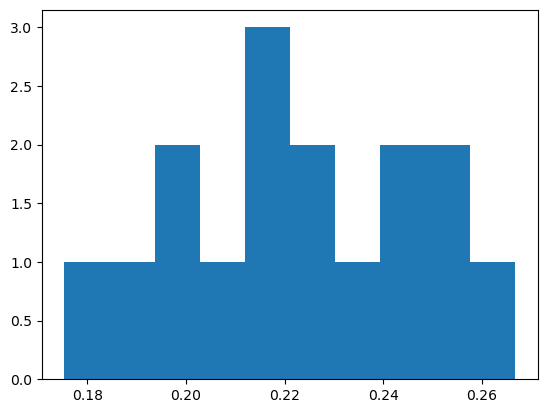

In [34]:
plt.hist(bws)

In [37]:
bws.mean(), bws.std()

(0.22243932160912389, 0.02491898396775335)

In [35]:
plt.plot(bws, epses, "o")
plt.yscale("log")
plt.xscale("log")

NameError: name 'epses' is not defined

In [ ]:
plt.imshow(resampled_cmap.reshape(l, l).T, origin="lower", cmap="seismic", norm=CenteredNorm())
plt.colorbar()

NameError: name 'resampled_cmap' is not defined

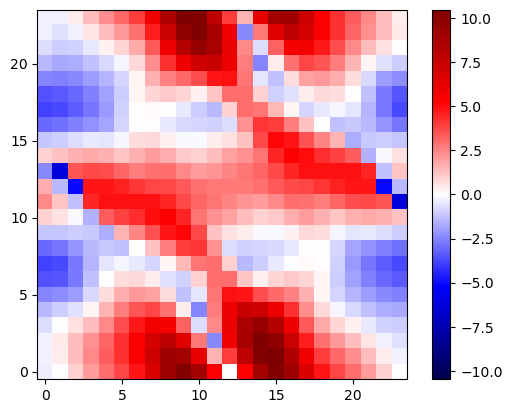

In [ ]:
plt.imshow(grid.T, origin="lower", cmap="seismic", norm=CenteredNorm())
plt.colorbar()